In [1]:
from nn_globals import *

from nn_encode import nlayers, nvariables

from nn_data import muon_data, pileup_data, muon_data_split, pileup_data_split

from nn_models import create_model, create_model_sequential, \
                      lr_decay, modelbestcheck, modelbestcheck_weights

from nn_training import train_model, train_model_sequential

%matplotlib inline

2018-07-23 23:31:55,722 [INFO    ] Using cmssw CMSSW_10_1_7
2018-07-23 23:31:55,895 [INFO    ] Using numpy 1.14.1
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs_depscipy/3.0-omkpbe5/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2018-07-23 23:31:58,887 [INFO    ] Using tensorflow 1.5.0
Using TensorFlow backend.
2018-07-23 23:31:58,990 [INFO    ] Using keras 2.1.4
2018-07-23 23:31:59,000 [INFO    ] .. list devices: [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
2018-07-23 23:31:59,070 [INFO    ] Using sklearn 0.19.2


In [2]:
# Import muon data
x_train, x_test, y_train, y_test, w_train, w_test, x_mask_train, x_mask_test = \
    muon_data_split(infile_muon, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, test_size=0.275)

# Add discrimator output node
if add_noise:
  labels = np.where(np.abs(1.0/y_train) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_train = [y_train, labels.astype(np.float32)]
  labels = np.where(np.abs(1.0/y_test) >= discr_pt_cut/reg_pt_scale, 1., mask_value)
  y_test = [y_test, labels.astype(np.float32)]

2018-07-23 23:31:59,666 [INFO    ] Loading muon data ...
2018-07-23 23:32:05,551 [INFO    ] Loaded the variables with shape (3350150, 87)
2018-07-23 23:32:05,553 [INFO    ] Loaded the parameters with shape (3350150, 3)
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-numpy/1.14.1-omkpbe2/lib/python2.7/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
nn_encode.py:86: RuntimeWarning: invalid value encountered in greater
  x_theta_tmp   = np.abs(self.x_theta) > theta_cuts
2018-07-23 23:32:18,011 [INFO    ] Loaded # of training and testing events: (2428858, 921292)


In [3]:
# Import pileup data
pu_x_train, pu_x_test, pu_aux_train, pu_aux_test, pu_w_train, pu_w_test, pu_x_mask_train, pu_x_mask_test = \
    pileup_data_split(infile_pileup, adjust_scale=adjust_scale, reg_pt_scale=reg_pt_scale, discr_pt_cut=discr_pt_cut, test_job=30)

# Add output nodes for pileup data
if add_noise:
  pu_y_train = [np.zeros((pu_x_train.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_train.shape[0],), dtype=np.float32)]
  pu_y_test = [np.zeros((pu_x_test.shape[0],), dtype=np.float32) + mask_value, np.zeros((pu_x_test.shape[0],), dtype=np.float32)]

2018-07-23 23:32:18,057 [INFO    ] Loading pileup data ...
2018-07-23 23:32:18,667 [INFO    ] Loaded the variables with shape (378768, 87)
2018-07-23 23:32:18,668 [INFO    ] Loaded the auxiliary info with shape (378768, 4)
2018-07-23 23:32:19,938 [INFO    ] Loaded # of training and testing events: (182484, 195623)


In [4]:
# Create models

model = create_model(nvariables=nvariables, lr=learning_rate, discr_loss_weight=discr_loss_weight)

model_seq = create_model_sequential(nvariables=nvariables, lr=learning_rate)

In [5]:
# Training (Sequential)

if False:
  assert(keras.backend.backend() == 'tensorflow')

  history = train_model_sequential(model_seq, x_train, y_train[0] if isinstance(y_train, list) else y_train, 
                                   model_name='model', epochs=20, batch_size=256, 
                                   callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [6]:
# Training (Functional)

if False:
  assert(keras.backend.backend() == 'tensorflow')
  
  if add_noise:
    # Put together x_train & pu_x_train, y_train & pu_y_train
    assert(len(pu_y_train) == 2)
    assert(pu_x_train.shape[0] == pu_y_train[0].shape[0])
    assert(pu_x_train.shape[0] == pu_y_train[1].shape[0])
    num_samples = pu_x_train.shape[0]
    index_array = np.arange(num_samples)
    index_array_ext = np.tile(index_array, 14)  # 14 is chosen to make sure pu_x_train_ext has more events than x_train
    pu_x_train_ext = pu_x_train[index_array_ext]
    pu_y_train_ext = [pu_y_train[0][index_array_ext], pu_y_train[1][index_array_ext]]
    
    assert(x_train.shape[0] < pu_x_train_ext.shape[0])
    num_samples = x_train.shape[0]
    index_array = np.arange(num_samples)
    #np.random.shuffle(index_array)
    
    try:
      from keras.engine.training import _make_batches as make_batches
    except ImportError:
      from keras.engine.training_utils import make_batches
      
    sample_batch_size = 128
    batches = make_batches(num_samples, sample_batch_size)
    
    x_train_new = np.zeros((num_samples*2, x_train.shape[1]), dtype=np.float32)
    y_train_new = [np.zeros((num_samples*2,), dtype=np.float32), np.zeros((num_samples*2,), dtype=np.float32)]
    
    for batch_index, (batch_start, batch_end) in enumerate(batches):
      batch_ids = index_array[batch_start:batch_end]      
      x_train_new[batch_start*2:batch_start*2 + (batch_end-batch_start)] = x_train[batch_ids]
      x_train_new[batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_x_train_ext[batch_ids]
      y_train_new[0][batch_start*2:batch_start*2 + (batch_end-batch_start)] = y_train[0][batch_ids]
      y_train_new[0][batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_y_train_ext[0][batch_ids]
      y_train_new[1][batch_start*2:batch_start*2 + (batch_end-batch_start)] = y_train[1][batch_ids]
      y_train_new[1][batch_start*2 + (batch_end-batch_start):batch_end*2] = pu_y_train_ext[1][batch_ids]
  else:
    raise Exception('add_noise must be set to True')
  
  logger.info('Mixed muon data with pileup data. x_train_new has shape {0}, y_train_new has shape {1},{2}'.format(x_train_new.shape, y_train_new[0].shape, y_train_new[1].shape))

  history = train_model(model, x_train_new, y_train_new,
                        model_name='model', epochs=200, batch_size=256, 
                        callbacks=[lr_decay,modelbestcheck,modelbestcheck_weights], validation_split=0.1, verbose=1)
  
  logger.info('Epoch {0}/{0} - loss: {1} - val_loss {2}'.format(len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]))

In [7]:
# Validation
#loss_and_metrics = model.evaluate(x_test, y_test, batch_size=2048)

if False:
  # Loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

if False:
  plt.plot(history.history['regr_loss'])
  plt.plot(history.history['val_regr_loss'])
  plt.title('regr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['discr_loss'])
  plt.plot(history.history['val_discr_loss'])
  plt.title('discr loss')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

### Regression Results

In [8]:
from nn_models import load_my_model

loaded_model = load_my_model(name='model')

nentries_test = x_test.shape[0]//5

# Prepare y_test_true, y_test_meas
y_test_true = y_test
if isinstance(y_test_true, list):
  y_test_true = y_test_true[0]
y_test_true = y_test_true[:nentries_test].copy()
y_test_true = y_test_true.reshape(-1)
y_test_true /= reg_pt_scale

y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)
if isinstance(y_test_meas, list):
  y_test_meas = y_test_meas[0]
y_test_meas = y_test_meas.reshape(-1)
y_test_meas /= reg_pt_scale

print y_test_true.shape, y_test_true
print y_test_meas.shape, y_test_meas

2018-07-23 23:32:21,240 [INFO    ] Loaded model from model.json and weights from model_weights.h5


(184258,) [-0.13722923  0.14607441 -0.08230478 ... -0.36348152 -0.46815544
  0.24576946]
(184258,) [-0.14203764  0.13682735 -0.08476605 ... -0.356768   -0.46523738
  0.21331508]


In [9]:
# Setup matplotlib
plt.style.use('tdrstyle.mplstyle')
eps = 1e-4
my_cmap = plt.cm.viridis
my_cmap.set_under('w',1)

# Setup for Gaussian fit
from scipy.stats import norm
from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
  return 0.5*a*np.exp(-np.square((x-x0)/sigma))

def fit_gaus(hist, edges, mu=0., sig=1.):
  xdata = (edges[:-1] + edges[1:])/2
  ydata = hist
  popt, pcov = curve_fit(gaus, xdata, ydata, p0=[np.max(hist),mu,sig])
  return popt

2018-07-23 23:32:21,611 [INFO    ] # of entries: 184258, mean: -0.00177806604188, std: 0.0323210321367
2018-07-23 23:32:21,616 [INFO    ] gaus fit (a, mu, sig): [ 3.93641219e+04 -1.95307285e-03  2.81784173e-02]


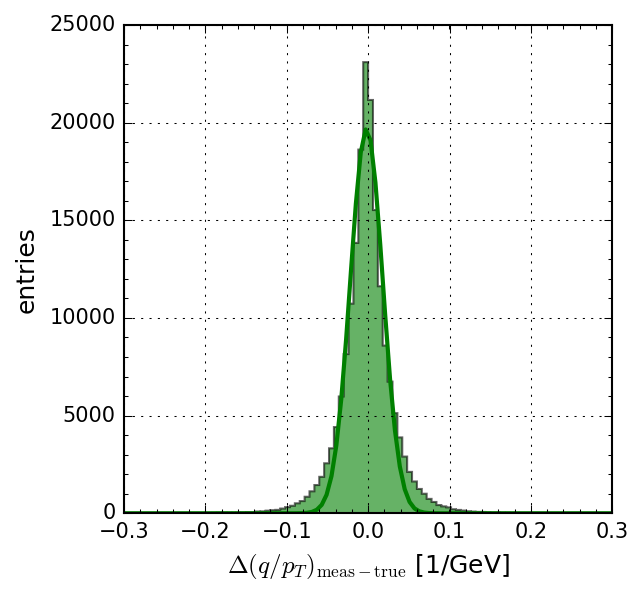

In [10]:
plt.figure()
yy = y_test_meas - y_test_true
hist, edges, _ = plt.hist(yy, bins=100, range=(-0.3,0.3-eps), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<0.3])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<0.3]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[:-1] + edges[1:])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

2018-07-23 23:32:22,489 [INFO    ] # of entries: 184258, mean: 0.0980531200767, std: 0.205804616213
2018-07-23 23:32:22,495 [INFO    ] gaus fit (a, mu, sig): [ 4.71115966e+04 -1.00147083e-02  1.59846539e-01]


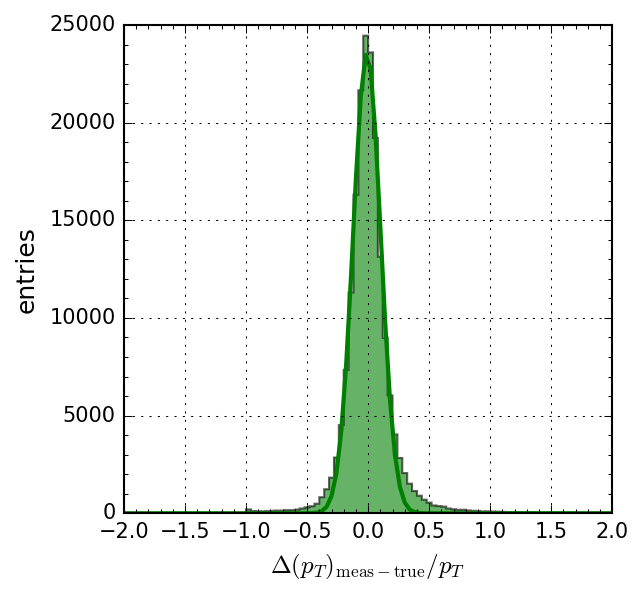

In [11]:
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
hist, edges, _ = plt.hist(yy, bins=100, range=(-2,2), histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
plt.ylabel(r'entries')
logger.info('# of entries: {0}, mean: {1}, std: {2}'.format(len(yy), np.mean(yy), np.std(yy[np.abs(yy)<2])))

popt = fit_gaus(hist, edges, mu=np.mean(yy), sig=np.std(yy[np.abs(yy)<1.5]))
logger.info('gaus fit (a, mu, sig): {0}'.format(popt))
xdata = (edges[:-1] + edges[1:])/2
plt.plot(xdata, gaus(xdata, popt[0], popt[1], popt[2]))
plt.show()

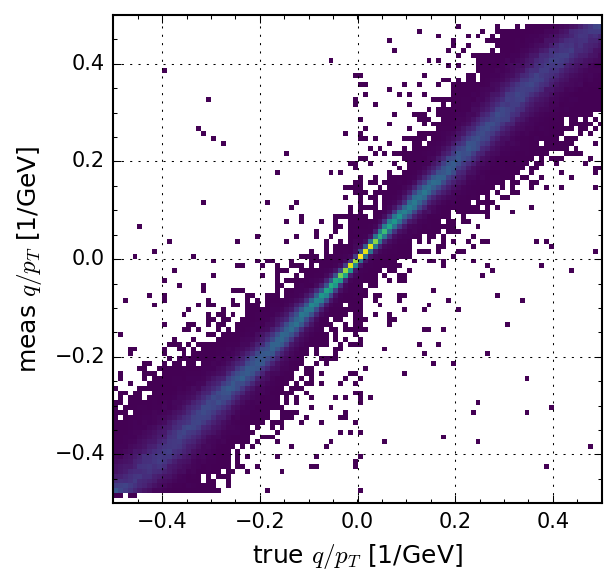

In [12]:
plt.figure()
plt.hist2d(y_test_true, y_test_meas, bins=(100,100), range=((-0.5,0.5),(-0.5,0.5)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'meas $q/p_{T}$ [1/GeV]')
#plt.colorbar()
plt.show()

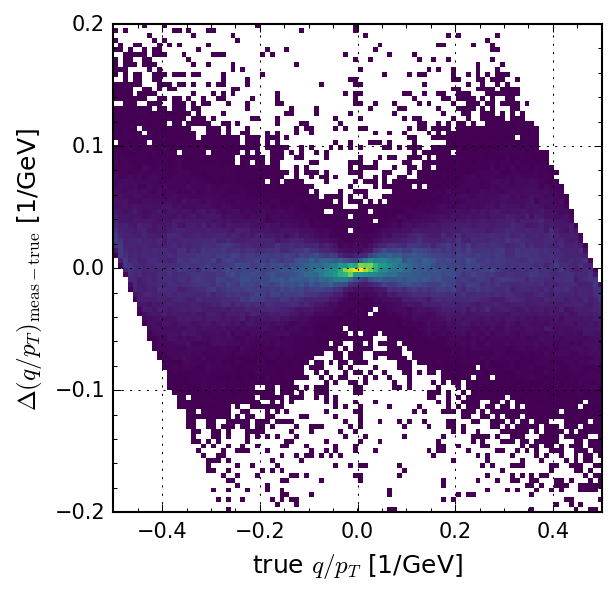

In [13]:
plt.figure()
yy = y_test_meas - y_test_true
plt.hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-0.2,0.2)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}}$ [1/GeV]')
#plt.colorbar()
plt.show()

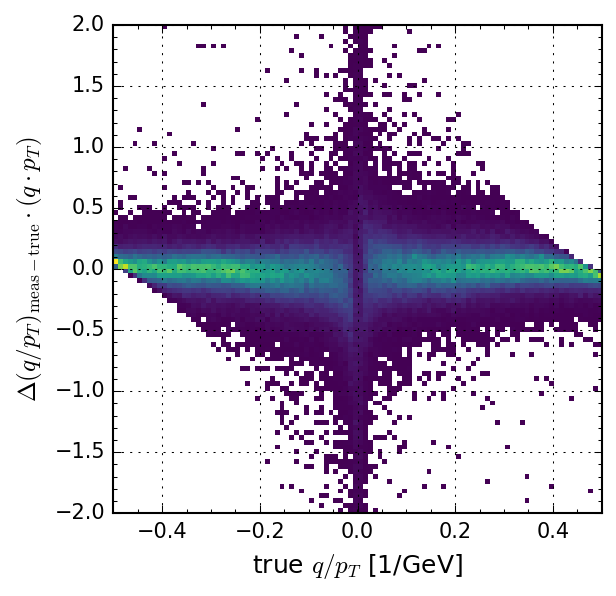

In [14]:
plt.figure()
yy = (y_test_meas - y_test_true)/np.abs(y_test_true)
plt.hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(q/p_{T})_{\mathrm{meas-true}} \cdot (q \cdot p_{T})$')
#plt.colorbar()
plt.show()

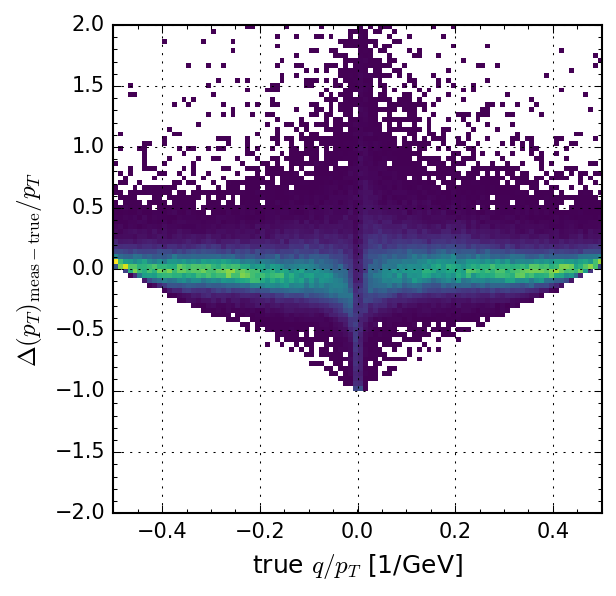

In [15]:
plt.figure()
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
plt.hist2d(y_test_true, yy, bins=(100,100), range=((-0.5,0.5),(-2,2)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $q/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
#plt.colorbar()
plt.show()

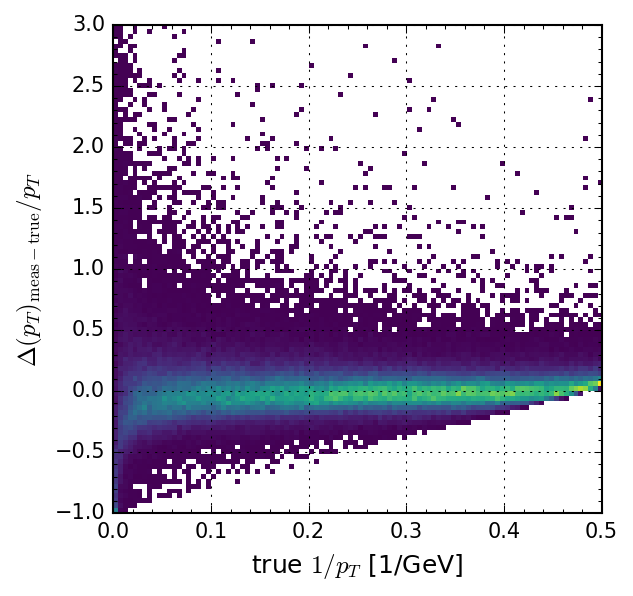

In [16]:
plt.figure()
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)
plt.hist2d(xx, yy, bins=(100,100), range=((0,0.5),(-1,3)), vmin=1, cmap=my_cmap)
plt.xlabel(r'true $1/p_{T}$ [1/GeV]')
plt.ylabel(r'$\Delta(p_{T})_{\mathrm{meas-true}} / p_{T}$')
#plt.colorbar()
plt.show()

In [17]:
# Make resolution plot
xx = np.abs(y_test_true)
yy = (np.abs(1.0/y_test_meas) - np.abs(1.0/y_test_true))/np.abs(1.0/y_test_true)

nbinsx = 100
xedges = np.linspace(0, 0.5, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
yyy = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  pt = np.mean(xx_i)
  pt = 1.0/pt
  
  yy_i = yy[inds==i]
  yy_i = yy_i[np.abs(yy_i) < 2]
  mu, sig = np.mean(yy_i), np.std(yy_i)
  assert(np.abs(mu) < 1)
  assert(np.abs(sig) < 2)
  
  hist, edges = np.histogram(yy_i, bins=100, range=(-2,2))
  popt = fit_gaus(hist, edges, mu=mu, sig=sig)
  #print i, len(xx_i), mu, sig, pt, popt
  
  if 20. < pt < 22.:
    xx_20GeV, yy_20GeV, popt_20GeV = xx_i, yy_i, popt
  
  xxx[i] = pt
  yyy[i] = popt[2]

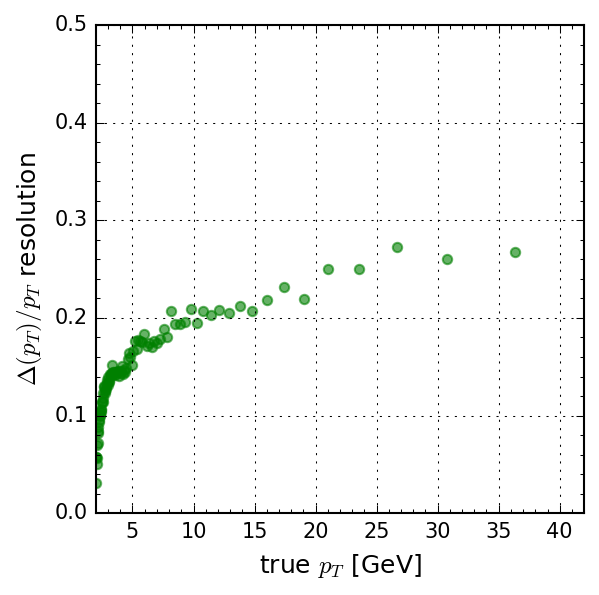

In [18]:
plt.figure()
plt.scatter(xxx, yyy, color='g', alpha=0.6)
plt.xlim(2,42)
plt.ylim(0,0.5)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'$\Delta(p_{T}) / p_{T}$ resolution')
plt.show()

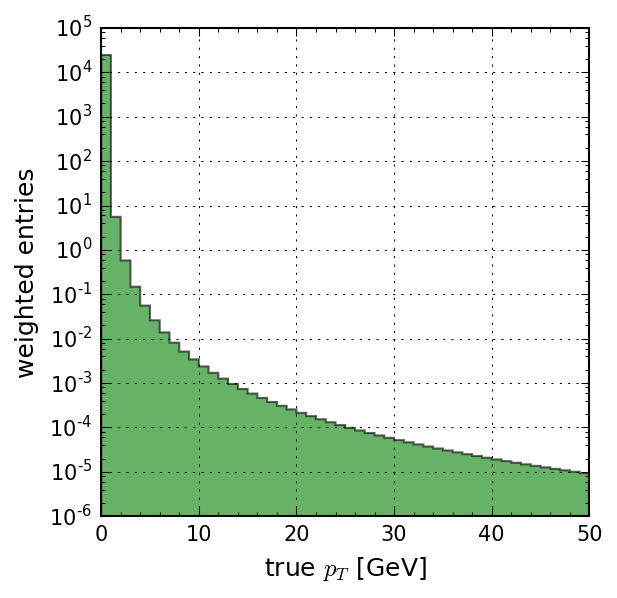

In [19]:
xx = np.linspace(0.1, 49.1, num=50)
#reweight = lambda x: 5.5 * np.power(x,-3)
#reweight = lambda x: 11 * np.power(x,-4)
reweight = lambda x: 7.778 * np.power(x,-3.5)
xw = np.fromiter((reweight(xi) for xi in xx), xx.dtype)

plt.figure()
plt.hist(xx, bins=50, range=(0,50), weights=xw, histtype='stepfilled', facecolor='g', alpha=0.6)
plt.xlabel(r'true $p_{T}$ [GeV]')
plt.ylabel(r'weighted entries')
plt.yscale('log')
plt.show()

In [20]:
xx = np.abs(1.0/y_test_true)
yy = np.abs(1.0/y_test_meas)

reweight = lambda x, y, thresh: 7.778 * np.power(x,-2.5) if y >= thresh else 0.  # -2.5 instead of -3.5 because the parent distribution is already 1/pT-weighted

nbinsx = 20
xedges = np.linspace(2, 42, num=nbinsx+1)
inds = np.digitize(xx, xedges[1:])

xxx = np.zeros(nbinsx, dtype=np.float32)
for i in xrange(nbinsx):
  xx_i = xx[inds==i]
  yy_i = yy[inds==i]
  pct = np.percentile(yy_i, [10, 50, 90], overwrite_input=True)
  #print np.mean(xx_i), len(xx_i), pct
  
  xxx[i] = pct[0]

ind_20GeV = np.digitize(20., xedges[1:])
thresh_20GeV = xxx[ind_20GeV]
yw = np.fromiter((reweight(xi, yi, thresh_20GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
print "20 GeV threshold", ind_20GeV, thresh_20GeV, np.sum(yw)

ind_22GeV = np.digitize(22., xedges[1:])
thresh_22GeV = xxx[ind_22GeV]
yw = np.fromiter((reweight(xi, yi, thresh_22GeV) for (xi, yi) in zip(xx, yy)), xx.dtype)
print "22 GeV threshold", ind_22GeV, thresh_22GeV, np.sum(yw)

20 GeV threshold 9 15.525873 96.234924
22 GeV threshold 10 16.83882 77.4975


In [21]:
from nn_models import NewKerasRegressor
estimator = NewKerasRegressor(build_fn=create_model_sequential, reg_pt_scale=reg_pt_scale, min_pt=20., max_pt=22., coverage=90.,
                              nvariables=nvariables, lr=learning_rate)

estimator.model = loaded_model

print estimator.score(x_test[:nentries_test], y_test[0][:nentries_test] if isinstance(y_test, list) else y_test)

-96.234924


### Classification Results

In [22]:
# Prepare y_test_true, y_test_meas
y_test_true = [y_test[0][:nentries_test, np.newaxis], y_test[1][:nentries_test, np.newaxis]]
y_test_meas = loaded_model.predict(x_test[:nentries_test], batch_size=2048)

y_test_true_tmp = (y_test_true[1] != mask_value)  # skip low pT muons
y_test_true = [y_test_true[0][y_test_true_tmp], y_test_true[1][y_test_true_tmp]]
y_test_meas = [y_test_meas[0][y_test_true_tmp], y_test_meas[1][y_test_true_tmp]]
y_test_true[0] /= reg_pt_scale
y_test_meas[0] /= reg_pt_scale

print y_test_true[0].shape, y_test_true[0], y_test_true[1].shape, y_test_true[1]
print y_test_meas[0].shape, y_test_meas[0], y_test_meas[1].shape, y_test_meas[1]

# Prepare pu_y_test_true, pu_y_test_meas
pu_y_test_true = [pu_y_test[0], pu_y_test[1]]
pu_y_test_meas = loaded_model.predict(pu_x_test, batch_size=2048)
pu_y_test_meas = [pu_y_test_meas[0].reshape(-1), pu_y_test_meas[1].reshape(-1)]
#pu_y_test_true[0] /= reg_pt_scale
pu_y_test_meas[0] /= reg_pt_scale

print pu_y_test_true[0].shape, pu_y_test_true[0], pu_y_test_true[1].shape, pu_y_test_true[1]
print pu_y_test_meas[0].shape, pu_y_test_meas[0], pu_y_test_meas[1].shape, pu_y_test_meas[1]

(29217,) [ 0.05887862 -0.01235009 -0.05027577 ...  0.05900069  0.00259824
  0.04285503] (29217,) [1. 1. 1. ... 1. 1. 1.]
(29217,) [ 0.04607395 -0.01133494 -0.06237943 ...  0.05803772  0.00460411
  0.03908756] (29217,) [0.999348   0.99966    0.9989328  ... 0.99998486 0.9999925  0.9999832 ]
(195623,) [100. 100. 100. ... 100. 100. 100.] (195623,) [0. 0. 0. ... 0. 0. 0.]
(195623,) [-0.32552034 -0.3253908   0.25611448 ... -0.4782297   0.47071442
 -0.47825053] (195623,) [1.21167315e-04 1.68838757e-04 2.23523326e-04 ... 2.76343030e-06
 2.29156376e-05 4.70091891e-06]


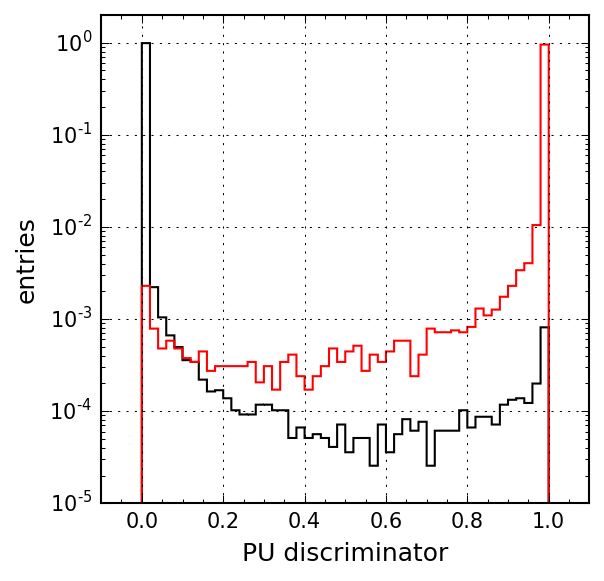

In [23]:
# Plot
plt.figure()
xx = pu_y_test_meas[1]
xw = np.ones_like(xx)/float(len(xx))
yy = y_test_meas[1]
yw = np.ones_like(yy)/float(len(yy))
plt.hist(xx, bins=50, range=(0,1), weights=xw, histtype='step', color='black')
plt.hist(yy, bins=50, range=(0,1), weights=yw, histtype='step', color='red')
plt.xlabel(r'PU discriminator')
plt.ylabel(r'entries')
plt.xlim(-0.1, 1.1)
plt.ylim(1e-5, 2)
plt.yscale('log')
plt.show()

auc: 0.992702031459
thresh: [0.99911135 0.9986651  0.99740976 0.9943275  0.98861456 0.98169404
 0.96459055 0.8971363 ]
tpr: [0.90008295 0.92557122 0.95094638 0.970138   0.98054445 0.98582309
 0.99042305 0.995023  ]
fpr: [0.02048976 0.02348826 0.02948526 0.03398301 0.04047976 0.04197901
 0.04847576 0.06446777]


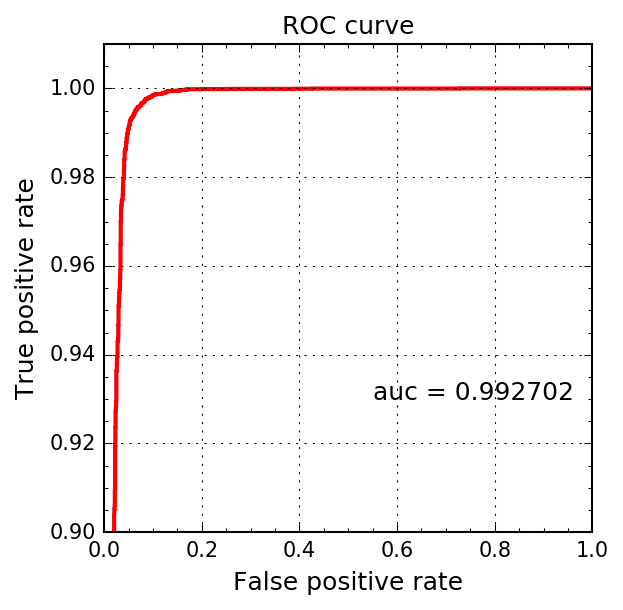

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score

xx = np.concatenate((y_test_true[1], pu_y_test_true[1]))
yy = np.concatenate((y_test_meas[1], pu_y_test_meas[1]))
zz = np.concatenate((y_test_meas[0], pu_y_test_meas[0]))

zz_tmp = np.abs(1.0/zz) > discr_pt_cut
xx = xx[zz_tmp]
yy = yy[zz_tmp]

fpr, tpr, thresh = roc_curve(xx, yy)  # (y_true, y_meas)
auc = roc_auc_score(xx, yy)           # (y_true, y_meas)

idx = np.searchsorted(tpr, [0.9, 0.925, 0.95, 0.97, 0.98, 0.985, 0.99, 0.995])
print("auc: {0}".format(auc))
print("thresh: {0}".format(thresh[idx]))
print("tpr: {0}".format(tpr[idx]))
print("fpr: {0}".format(fpr[idx]))

plt.figure()
plt.plot(fpr, tpr, 'r')
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.text(0.55, 0.93, r'auc = %f' % auc, fontsize=12)
plt.xlim(0.0,1.0)
plt.ylim(0.9,1.01)
plt.show()

### Efficiency & Rates 

In [25]:
if False:
  print x_train.shape, y_train[0].shape, x_mask_train.shape
  print np.mean(y_train[0]), np.std(y_train[0]), np.percentile(y_train[0], [2,98])
  
  fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    x_i = x_train[valid,i]
    y_i = y_train[0][valid]/reg_pt_scale

    xmin, xmax = -2, 2
    ymin, ymax = -0.6, 0.6
    if (nlayers) <= i < (nlayers*2):
      xmin, xmax = -3, 3
    
    hist = axs[(i/4, i%4)].hist2d(x_i, y_i, bins=40, range=[[xmin, xmax], [ymin, ymax]], cmap=plt.cm.viridis)  #norm=colors.LogNorm(),
    if x_i.size > 0:
      print i, np.mean(x_i), np.std(x_i), np.percentile(x_i, [2,98])

In [26]:
if False:
  from sklearn.linear_model import LinearRegression
  from sklearn.covariance import EmpiricalCovariance, MinCovDet

  print x_train.shape, y_train[0].shape, x_mask_train.shape

  #fig, axs = plt.subplots(80/4, 4, figsize=(4*4,4*80/4), tight_layout=True)
  
  coefs = np.ones((nlayers * 7) + 3)

  for i in xrange(x_train.shape[1]):
    lay = (i % nlayers)
    mask = x_mask_train[...,lay].copy()
    if i >= (nlayers*6):
      mask *= False
    
    valid = ~mask
    valid = valid & (np.abs(1.0/y_train[0]) < discr_pt_cut/reg_pt_scale)  # skip high pT part
    x_i = x_train[valid,i].copy()
    y_i = (y_train[0][valid]/reg_pt_scale).copy()
    
    nentries_test = 100000
    x_i = x_i[:nentries_test]
    y_i = y_i[:nentries_test]
    y_i /= (1.0/np.sqrt(12))  # stdev: (b-a)/sqrt(12)
    
    if x_i.size > 0 and np.std(x_i) > 0.:
      coef = 1.0
      
      # x_phi
      if (i < nlayers):
        mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
        coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
        
        #lr = LinearRegression(fit_intercept=False).fit(x_i[:,np.newaxis], y_i)
        #coef = lr.coef_[0]
        #print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_theta
      elif (nlayers) <= i < (nlayers*2):
        coef = 1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      # x_bend
      elif (nlayers*2) <= i < (nlayers*3):
        if lay in (0,1) or lay in (11,):  # ME1/1, ME1/2, ME0
          mcd = MinCovDet(assume_centered=True).fit(np.column_stack((x_i,y_i)))
          coef = mcd.covariance_[0,1] / mcd.covariance_[0,0]  # Cov[x,y]/Var[x]
        elif lay in (2,) or lay in (5,6) or lay in (9,10):  # ME2, RE1, RE2, GE1/1, GE2/1
          coef = 1.0/np.std(x_i)
        else:  # ME3, ME4, RE3, RE4
          coef = -1.0/np.std(x_i)
        print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
    
      ## x_time
      #elif (nlayers*3) <= i < (nlayers*4):
      #  coef = 1.0/np.std(x_i)
      #  print i, coef, np.std(x_i), np.std(x_i * coef), np.std(y_i)
      
      coefs[i] = coef  

  print np.array2string(coefs, separator=', ', precision=6)

In [27]:
if False:
  # Tensorflow Interface for CMSSW
  # https://github.com/riga/CMSSW-DNN#keras
  
  import tensorflow as tf
  #sess = tf.Session()

  from keras import backend as K
  #K.set_session(sess)
  sess = K.get_session()

  # save at as a constant graph
  ## names found with: [node.op.name for node in loaded_model.outputs]
  ## to get all nodes: [n.name for n in tf.get_default_graph().as_graph_def().node]
  #outputs = [u'regr/BiasAdd', u'discr/Sigmoid']
  outputs = [u'dense_7_1/BiasAdd']
  constant_graph = tf.graph_util.convert_variables_to_constants(
      sess, sess.graph.as_graph_def(), outputs)
  tf.train.write_graph(constant_graph, "/tmp/jiafu", "constantgraph.pb", as_text=False)

  # save it as a SavedModel
  builder = tf.saved_model.builder.SavedModelBuilder("/tmp/jiafu/simplegraph")
  builder.add_meta_graph_and_variables(sess, [tf.saved_model.tag_constants.SERVING])
  builder.save()